# Counterfactual Fairness Analysis

This notebook evaluates counterfactual fairness by swapping sensitive attributes (gender or ethnicity) while keeping AQ-10 answers fixed. The change in predicted probabilities (Δ probability) is recorded using the Random Forest model.

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Mean ROC-AUC: 0.9764198262855489 (95% CI: 0.9721711524095022, 0.9806685001615956)
Mean PR-AUC: 0.46874840250403627 (95% CI: 0.46147166138699697, 0.47602514362107556)
Mean F1 Score: 0.923588787021783 (95% CI: 0.9167846027906058, 0.9303929712529603)
Mean Matthews Correlation Coefficient: 0.8447693188740699 (95% CI: 0.8307730022197002, 0.8587656355284397)


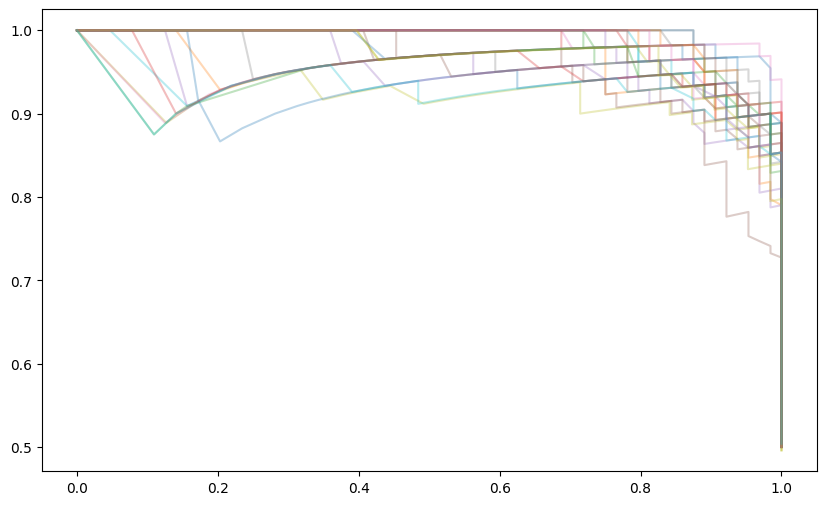

In [5]:
# Load the Random Forest model from SupervisedRandomForest notebook
%run SupervisedRandomForest.ipynb

In [18]:
def counterfactual_fairness_analysis(data, model, sensitive_column, fixed_columns):
    results = []
    for index, row in data.iterrows():
        original_row = row.copy()
        X_original = pd.DataFrame([row.drop(fixed_columns)])
        X_original = X_original.reindex(columns=model.feature_names_in_, fill_value=0)
        original_prob = model.predict_proba(X_original)[:, 1][0]


        # Swap sensitive attribute
        if sensitive_column == 'gender':
            row[sensitive_column] = 1 - row[sensitive_column]  # Swap gender
        elif sensitive_column == 'ethnicity':
            for col in row.index:
                if col.startswith('ethnicity_') and row[col] == 1:
                    row[col] = 0
                elif col.startswith('ethnicity_') and row[col] == 0:
                    row[col] = 1
                    break

        X_swapped = pd.DataFrame([row.drop(fixed_columns)])
        X_swapped = X_swapped.reindex(columns=model.feature_names_in_, fill_value=0)
        swapped_prob = model.predict_proba(X_swapped)[:, 1][0]

        delta_prob = swapped_prob - original_prob

        results.append({
            'Index': index,
            'Original_Probability': original_prob,
            'Swapped_Probability': swapped_prob,
            'Delta_Probability': delta_prob
        })

    return pd.DataFrame(results)

In [16]:
# Perform counterfactual fairness analysis for gender
sensitive_column = 'gender'
fixed_columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']

results_gender = counterfactual_fairness_analysis(cleanTest, rf_model, sensitive_column, fixed_columns)
print(results_gender) 

     Index  Original_Probability  Swapped_Probability  Delta_Probability
0        0                 0.070                0.105              0.035
1        1                 0.000                0.000              0.000
2        2                 0.045                0.080              0.035
3        3                 0.000                0.000              0.000
4        4                 0.000                0.000              0.000
..     ...                   ...                  ...                ...
195    195                 0.030                0.030              0.000
196    196                 0.005                0.010              0.005
197    197                 0.005                0.005              0.000
198    198                 0.000                0.000              0.000
199    199                 0.040                0.015             -0.025

[200 rows x 4 columns]


In [19]:
# Perform counterfactual fairness analysis for ethnicity
sensitive_column = 'ethnicity'

results_ethnicity = counterfactual_fairness_analysis(cleanTest, rf_model, sensitive_column, fixed_columns)
print(results_ethnicity)

     Index  Original_Probability  Swapped_Probability  Delta_Probability
0        0                 0.070                0.110              0.040
1        1                 0.000                0.000              0.000
2        2                 0.045                0.085              0.040
3        3                 0.000                0.000              0.000
4        4                 0.000                0.000              0.000
..     ...                   ...                  ...                ...
195    195                 0.030                0.030              0.000
196    196                 0.005                0.005              0.000
197    197                 0.005                0.005              0.000
198    198                 0.000                0.015              0.015
199    199                 0.040                0.040              0.000

[200 rows x 4 columns]
